<a href="https://colab.research.google.com/github/walefmachado/spatial_cluster/blob/master/scripts/spatial_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas

In [ ]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [ ]:
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/'
link_p = 'https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/'
link_w = 'https://raw.githubusercontent.com/walefmachado/Municipios-Brasileiros/master/csv/'

In [ ]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [ ]:
dados18 = pd.read_csv('https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/seguro18.csv',
                      encoding='utf-8')
dados18.head()

ano  uf  ... taxa_media apolices_indenizadas
0  2018  AC  ...       0.01                    0
1  2018  AL  ...      79.00                    1
2  2018  AL  ...       0.09                    0
3  2018  AL  ...       0.01                    0
4  2018  AL  ...       0.01                    0

[5 rows x 14 columns]

In [ ]:
dados = dados18
cod = pd.read_csv('https://patriciasiqueira.github.io/arquivos/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [ ]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [ ]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [ ]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [ ]:
dados.reset_index(level = 0, inplace = True)

In [ ]:
dados.shape

(2293, 9)

In [ ]:
dados = dados.merge(cod, on='mun')

In [ ]:
# dados = dados.loc[:, ['mun', 'nome_mun', 'nome_meso', 'apolices_contratadas', 'total_segurado_mil',
#       'soma_premio_total_mil', 'total_subvencao_mil',
#       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
#       'apolices_indenizadas']]

In [ ]:
dados.head()

mun  apolices_contratadas  ...           nome_mun          nome_meso
0  1100023.0                     1  ...          ariquemes  Leste Rondoniense
1  1100056.0                     2  ...         cerejeiras  Leste Rondoniense
2  1100072.0                     2  ...         corumbiara  Leste Rondoniense
3  1100130.0                     1  ...  machadinho_doeste  Leste Rondoniense
4  1100403.0                     2  ...       alto_paraiso  Leste Rondoniense

[5 rows x 11 columns]

In [ ]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [ ]:
# dados.to_csv(r'/home/walef/Dropbox/Mestrado/Dados/dados_multi_teste.csv',index=False, header= True)

In [ ]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [ ]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link_p+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [ ]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [ ]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [ ]:
dados_br = cod_dados.merge(seguro, how='left')

In [ ]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

In [ ]:
# dados_br.to_csv(r'/home/walef/Dropbox/Mestrado/Dados/dados_multi_spati_teste.csv',index=False, header= True)

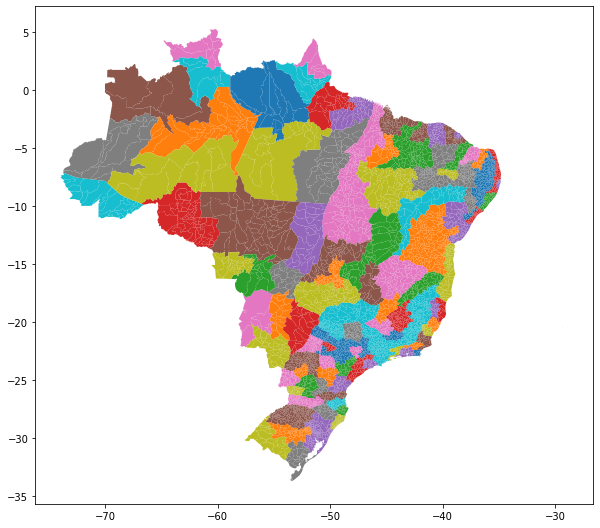

In [ ]:
# dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10), k=4); # , cmap='OrRd',  cmap='plasma'

## Matriz de I de Moran 

Teste de construção de uma matriz de I de Moran para cada variável


### Criando a matriz

In [ ]:
moran_matrix = dados_br
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # , 'geometry'
moran_matrix = moran_matrix.drop(retirar, axis = 1)

### I de Moran local para variáveis

In [ ]:
moran_matrix.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [ ]:
# demora um pouco
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [ ]:
moran_matrix['apolices_contratadas'] = Moran_Local(dados_br['apolices_contratadas'].values, w).Is
moran_matrix['total_segurado_mil'] = Moran_Local(dados_br['total_segurado_mil'].values, w).Is
moran_matrix['soma_premio_total_mil'] = Moran_Local(dados_br['soma_premio_total_mil'].values, w).Is
moran_matrix['total_subvencao_mil'] = Moran_Local(dados_br['total_subvencao_mil'].values, w).Is
moran_matrix['valor_indenizacoes_pagas_mil'] = Moran_Local(dados_br['valor_indenizacoes_pagas_mil'].values, w).Is
moran_matrix['sinistralidade_media'] = Moran_Local(dados_br['sinistralidade_media'].values, w).Is
moran_matrix['taxa_media'] = Moran_Local(dados_br['taxa_media'].values, w).Is
moran_matrix['apolices_indenizadas'] = Moran_Local(dados_br['apolices_indenizadas'].values, w).Is
# Podia ser feito de um jeito mais inteligente? Podia

In [ ]:
moran_matrix = moran_matrix.set_index('nome_mun')

In [ ]:
moran_matrix.describe()

apolices_contratadas  ...  apolices_indenizadas
count           5568.000000  ...           5568.000000
mean               0.526489  ...              0.504681
std                4.101609  ...              7.605073
min               -3.459365  ...             -2.706206
25%                0.034562  ...              0.023832
50%                0.072723  ...              0.033087
75%                0.076697  ...              0.033087
max              138.070704  ...            371.646238

[8 rows x 8 columns]

### Mapa I de Moran

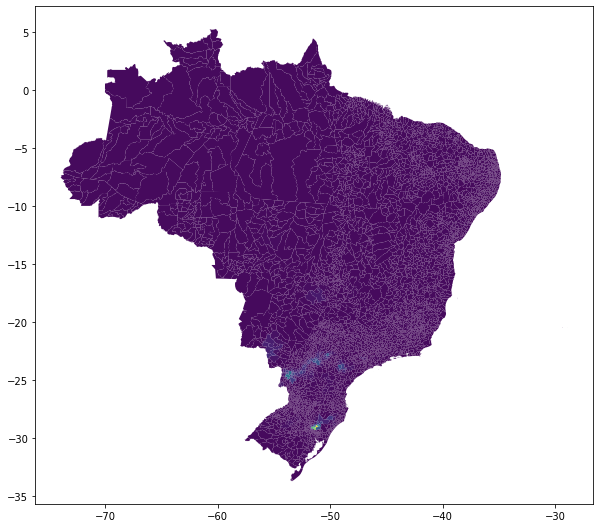

In [ ]:
moran_matrix.plot(column='apolices_contratadas', figsize=(10, 10),  k=4); # , cmap='OrRd'

## Análise de agrupamento - I de Moran

In [ ]:
# subselecionar variáveis
X = moran_matrix.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

In [ ]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(2000)

2000


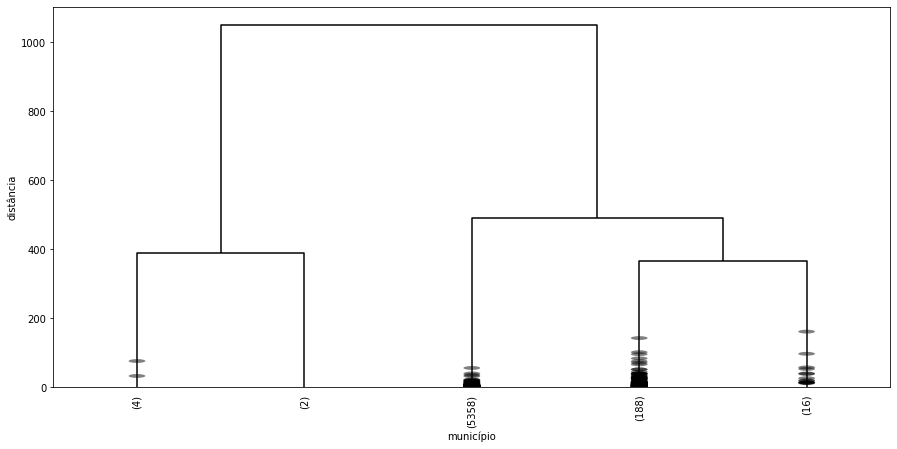

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
# definir a distância de corte baseando no dendrograma
max_d = 250
grupos = cut_tree(Z, height=max_d)

### Métricas

In [ ]:
retirar = ['uf', 'nome_uf', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry',] # 
dados_metrics = dados_br.drop(retirar, axis = 1)

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

1040.46 1.79 0.82


In [ ]:
  # incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
moran_matrix['grupo'] = grupos
# moran_matrix.head(2)

In [ ]:
# contagem de observações em cada grupo
moran_matrix.grupo.value_counts()

0    5358
1     188
2      16
3       4
4       2
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix.groupby('grupo').mean()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                  0.085529  ...              0.038799
1                  8.004665  ...              5.648517
2                 30.146854  ...             19.442346
3                 74.268232  ...            160.150617
4                 94.463457  ...            294.288232

[5 rows x 8 columns]

In [ ]:
# mediana das variáveis para cada grupo
moran_matrix.groupby('grupo').median()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                  0.070735  ...              0.033087
1                  5.465454  ...              3.285468
2                 21.374527  ...              5.561850
3                 75.457274  ...            152.254001
4                 94.463457  ...            294.288232

[5 rows x 8 columns]

### As observações de cada grupo


In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com I de Moran

In [ ]:
moran_matrix['grupo'] = moran_matrix['grupo'].astype('category')

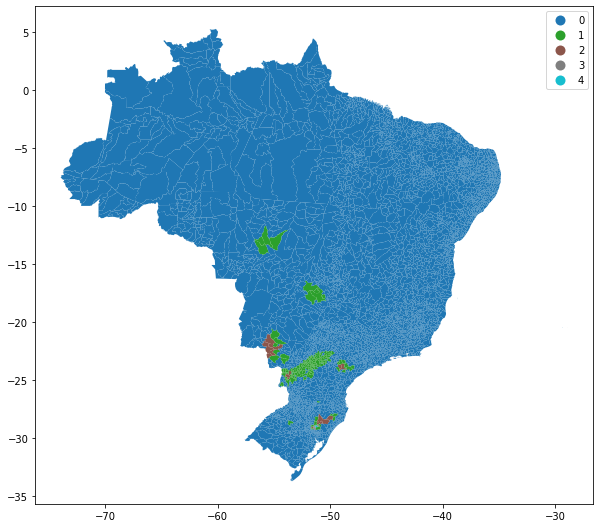

In [ ]:
moran_matrix.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## K-Médias - I de Moran


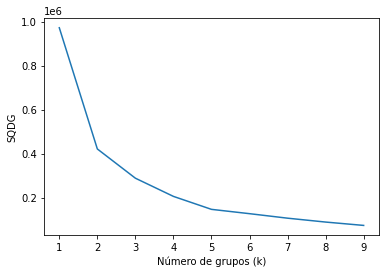

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(moran_matrix.drop('geometry', axis=1))
    moran_matrix['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [ ]:
k = 5

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

872.18 1.87 0.82


In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
moran_matrix['grupo'] = kmeans.labels_

In [ ]:
# contagens
moran_matrix.grupo.value_counts()

0    5420
3     127
4      14
2       5
1       2
Name: grupo, dtype: int64

In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix.groupby('grupo').mean()

apolices_contratadas  total_segurado_mil  ...  apolices_indenizadas    grupos
grupo                                            ...                                
0                  0.123769            0.177009  ...              0.053297  2.953690
1                 94.463457           20.545592  ...            294.288232  3.000000
2                 79.808580           18.011640  ...            147.076555  3.200000
3                 11.508287            5.602952  ...              8.917169  3.118110
4                 15.081702           36.114870  ...              4.625204  4.642857

[5 rows x 9 columns]

In [ ]:
# mediana das variáveis para cada grupo
moran_matrix.groupby('grupo').median()

apolices_contratadas  total_segurado_mil  ...  apolices_indenizadas  grupos
grupo                                            ...                              
0                  0.071928            0.079291  ...              0.033087       3
1                 94.463457           20.545592  ...            294.288232       3
2                 81.022871           21.808463  ...            150.432289       2
3                  8.114706            3.573633  ...              5.795227       4
4                 12.868058           37.363125  ...              3.544435       4

[5 rows x 9 columns]

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com I de Moran

In [ ]:
moran_matrix['grupo'] = moran_matrix['grupo'].astype('category')

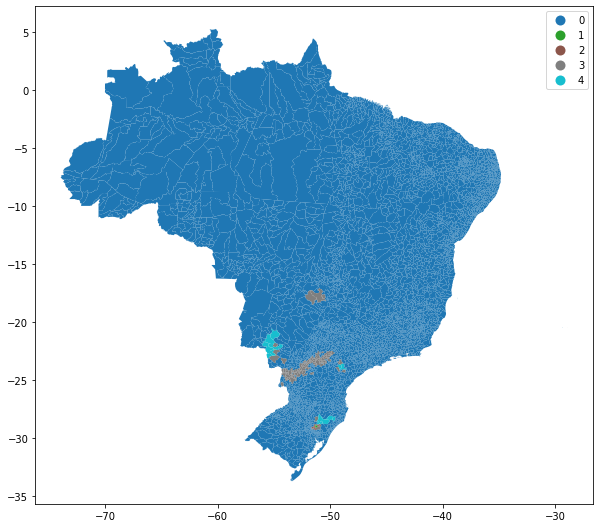

In [ ]:
moran_matrix.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## Matriz de G de Getis-Ord


Teste de construção de uma matriz de G de Getis-Ord para cada variável


### Criando a matriz

In [ ]:
getis_matrix = dados_br

In [ ]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # , 'geometry'
getis_matrix = getis_matrix.drop(retirar, axis = 1)

### G de Getis-Ord local para variáveis

In [ ]:
getis_matrix.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [ ]:
# demora um pouco
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [ ]:
getis_matrix['apolices_contratadas'] = G_Local(dados_br['apolices_contratadas'].values, w).Zs
getis_matrix['total_segurado_mil'] = G_Local(dados_br['total_segurado_mil'].values, w).Zs
getis_matrix['soma_premio_total_mil'] = G_Local(dados_br['soma_premio_total_mil'].values, w).Zs
getis_matrix['total_subvencao_mil'] = G_Local(dados_br['total_subvencao_mil'].values, w).Zs
getis_matrix['valor_indenizacoes_pagas_mil'] = G_Local(dados_br['valor_indenizacoes_pagas_mil'].values, w).Zs
getis_matrix['sinistralidade_media'] = G_Local(dados_br['sinistralidade_media'].values, w).Zs
getis_matrix['taxa_media'] = G_Local(dados_br['taxa_media'].values, w).Zs
getis_matrix['apolices_indenizadas'] = G_Local(dados_br['apolices_indenizadas'].values, w).Zs
# Podia ser feito de um jeito mais inteligente? Podia

In [ ]:
getis_matrix = getis_matrix.set_index('nome_mun')

In [ ]:
getis_matrix.describe()

apolices_contratadas  ...  apolices_indenizadas
count           5568.000000  ...           5568.000000
mean               0.040838  ...              0.022450
std                0.812388  ...              0.774895
min               -0.277323  ...             -0.182899
25%               -0.276994  ...             -0.181931
50%               -0.250084  ...             -0.181931
75%               -0.056141  ...             -0.110195
max               10.444671  ...             17.554673

[8 rows x 8 columns]

### Mapa G de Getis-Ord

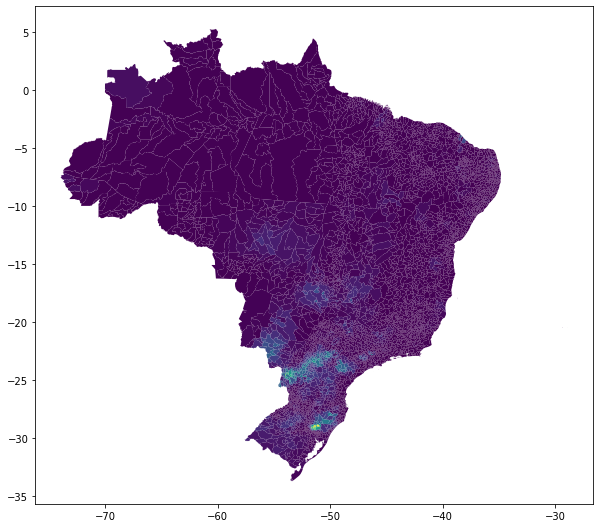

In [ ]:
getis_matrix.plot(column='apolices_contratadas', figsize=(10, 10),   k=4); # , cmap='OrRd'

## Análise de agrupamento - G de Getis-Ord

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

In [ ]:
# subselecionar variáveis
X = getis_matrix.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

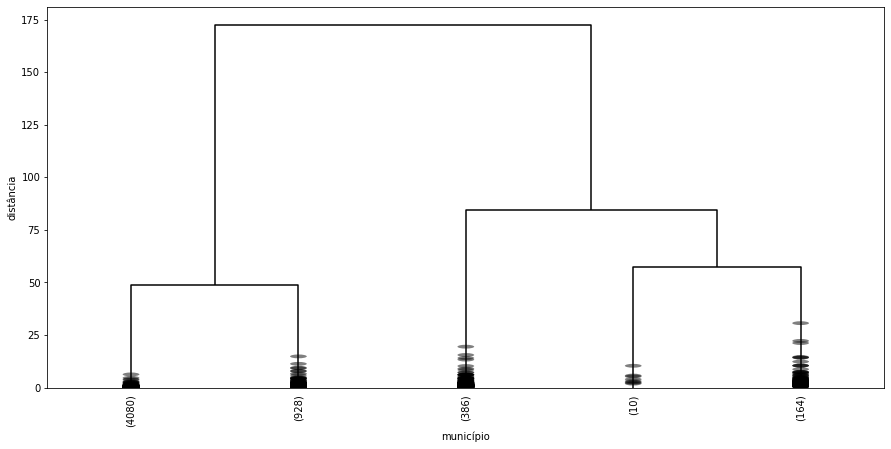

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
# definir a distância de corte baseando no dendrograma
max_d = 40
grupos = cut_tree(Z, height=max_d)

### Métricas

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

403.03 3.72 0.44


In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
getis_matrix['grupo'] = grupos
# moran_matrix.head(2)

In [ ]:
# contagem de observações em cada grupo
getis_matrix.grupo.value_counts()

0    4080
1     928
2     386
4      88
3      76
5      10
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix.groupby('grupo').mean()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                 -0.239194  ...             -0.171935
1                  0.167822  ...              0.038341
2                  1.154613  ...              0.706918
3                  2.341966  ...              1.323426
4                  3.911890  ...              3.443404
5                  7.963940  ...             11.444352

[6 rows x 8 columns]

In [ ]:
# mediana das variáveis para cada grupo
getis_matrix.groupby('grupo').median()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                 -0.271612  ...             -0.181931
1                  0.079949  ...             -0.029300
2                  1.048103  ...              0.428619
3                  2.361790  ...              1.096388
4                  3.693796  ...              2.930017
5                  7.775493  ...              9.932141

[6 rows x 8 columns]

### As observações de cada grupo

In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

In [ ]:
#grupo1 = dados.query('grupo == 1').index
#list(grupo1)

In [ ]:
#grupo2 = dados.query('grupo == 2').index
#list(grupo2)

In [ ]:
# plotar os escores dos CPs dos grupos
#sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=moran_matrix, aspect=1.5);

In [ ]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor
# import altair as alt

### Mapa Grupos G de Getis Ord

In [ ]:
getis_matrix['grupo'] = getis_matrix['grupo'].astype('category')

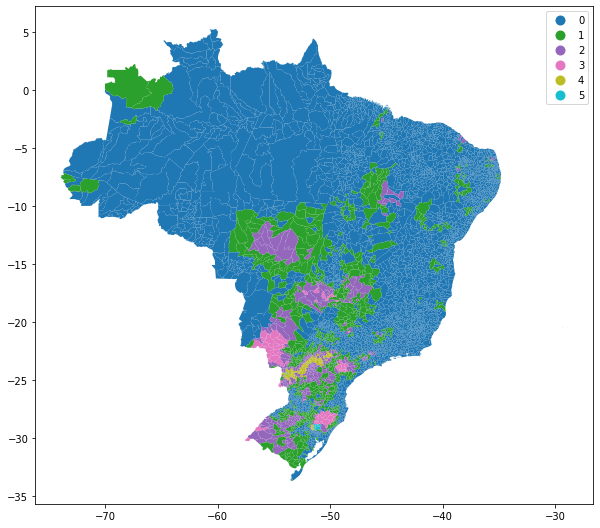

In [ ]:
getis_matrix.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## K-Médias - G de Getis-Ord

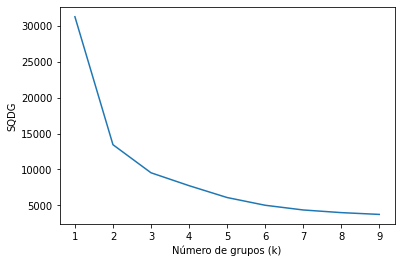

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(getis_matrix.drop('geometry', axis=1))
    getis_matrix['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [ ]:
k = 3

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
getis_matrix['grupo'] = kmeans.labels_

### Métricas

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

863.2 1.76 0.65


In [ ]:
# contagens
getis_matrix.grupo.value_counts()

0    4827
2     564
1     177
Name: grupo, dtype: int64

In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix.groupby('grupo').mean()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                 -0.187784  ...             -0.147174
1                  3.533527  ...              3.078630
2                  0.901386  ...              0.515057

[3 rows x 8 columns]

In [ ]:
# mediana das variáveis para cada grupo
getis_matrix.groupby('grupo').median()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                 -0.265030  ...             -0.181931
1                  3.175929  ...              2.516075
2                  0.758998  ...              0.311137

[3 rows x 8 columns]

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

In [ ]:
#grupo1 = mg.query('grupo == 1').index
#list(grupo1)

In [ ]:
#grupo2 = mg.query('grupo == 2').index
#list(grupo2)

### Mapa Grupos com G de Getis Ord 

In [ ]:
getis_matrix['grupo'] = getis_matrix['grupo'].astype('category')

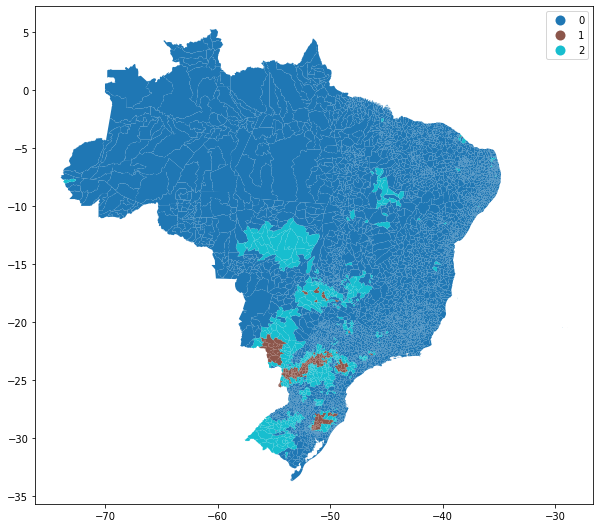

In [ ]:
getis_matrix.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## Sul

In [ ]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

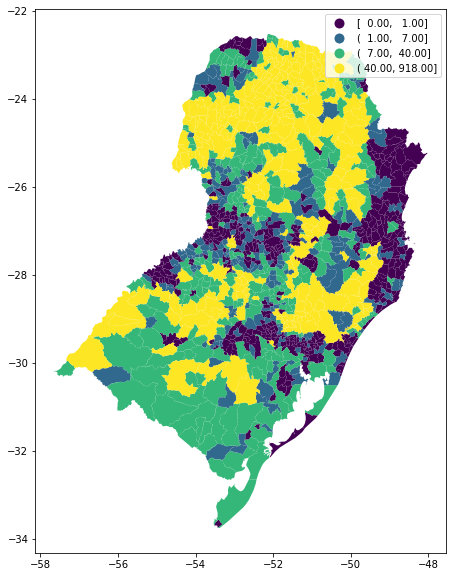

In [ ]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True, k=4); # , cmap='OrRd'

## Matriz de I de Moran - Sul

Teste de construção de uma matriz de I de Moran para cada variável


### Criando a matriz

In [ ]:
dados_sul.columns

Index(['Unnamed: 0', 'uf', 'nome_uf', 'mun', 'nome_mun', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'codmun6', 'regiao', 'nome_regiao',
       'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [ ]:
moran_matrix_sul = dados_sul

In [ ]:
retirar = ['uf', 'rm', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'Unnamed: 0'] #  'geometry',
moran_matrix_sul = moran_matrix_sul.drop(retirar, axis = 1)

### I de Moran local para variáveis

In [ ]:
moran_matrix_sul.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [ ]:
moran_matrix_sul.describe()

apolices_contratadas  ...  apolices_indenizadas
count           1191.000000  ...           1191.000000
mean              37.428212  ...             11.761545
std               79.148481  ...             38.047187
min                0.000000  ...              0.000000
25%                1.000000  ...              0.000000
50%                7.000000  ...              1.000000
75%               40.000000  ...              6.000000
max              918.000000  ...            771.000000

[8 rows x 8 columns]

In [ ]:
# demora um pouco
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [ ]:
moran_matrix_sul['apolices_contratadas'] = Moran_Local(dados_sul['apolices_contratadas'].values, w).Is
moran_matrix_sul['total_segurado_mil'] = Moran_Local(dados_sul['total_segurado_mil'].values, w).Is
moran_matrix_sul['soma_premio_total_mil'] = Moran_Local(dados_sul['soma_premio_total_mil'].values, w).Is
moran_matrix_sul['total_subvencao_mil'] = Moran_Local(dados_sul['total_subvencao_mil'].values, w).Is
moran_matrix_sul['valor_indenizacoes_pagas_mil'] = Moran_Local(dados_sul['valor_indenizacoes_pagas_mil'].values, w).Is
moran_matrix_sul['sinistralidade_media'] = Moran_Local(dados_sul['sinistralidade_media'].values, w).Is
moran_matrix_sul['taxa_media'] = Moran_Local(dados_sul['taxa_media'].values, w).Is
moran_matrix_sul['apolices_indenizadas'] = Moran_Local(dados_sul['apolices_indenizadas'].values, w).Is
# Podia ser feito de um jeito mais inteligente? Podia

In [ ]:
moran_matrix_sul = moran_matrix_sul.set_index('nome_mun')

In [ ]:
moran_matrix_sul.describe()

apolices_contratadas  ...  apolices_indenizadas
count           1191.000000  ...           1191.000000
mean               0.554577  ...              0.526146
std                2.496036  ...              4.066280
min               -0.851689  ...             -0.448808
25%                0.036658  ...              0.044636
50%                0.155966  ...              0.084187
75%                0.215086  ...              0.095562
max               42.812370  ...             93.833055

[8 rows x 8 columns]

### Mapa I de Moran - Sul

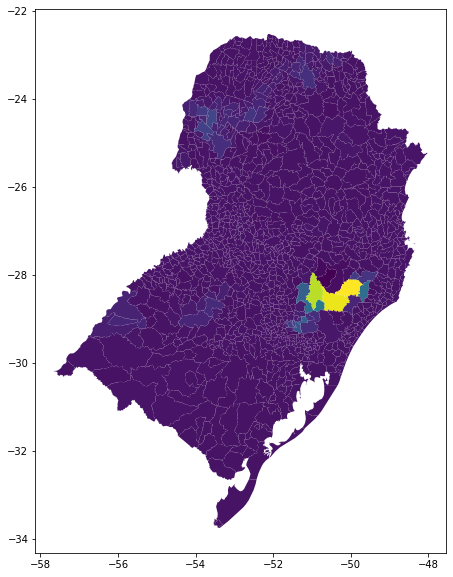

In [ ]:
moran_matrix_sul.plot(column='soma_premio_total_mil', figsize=(10, 10),  k=4); # , cmap='OrRd'

## Análise de agrupamento - I de Moran - Sul

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

In [ ]:
# subselecionar variáveis
X = moran_matrix_sul.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

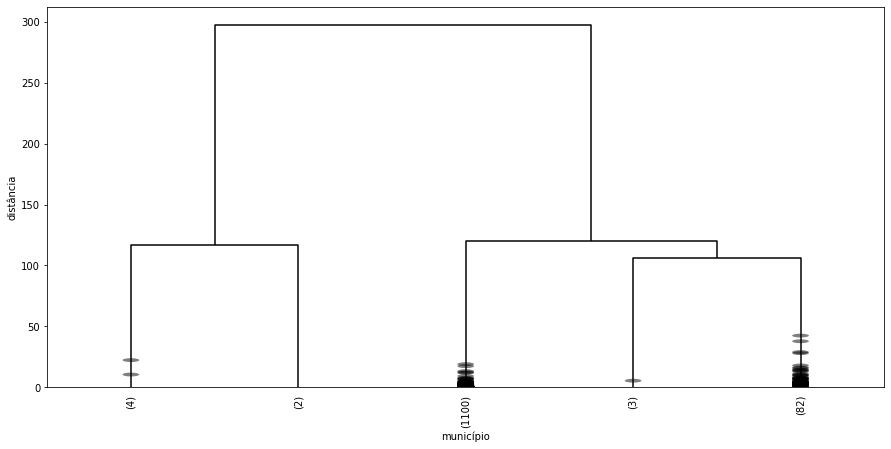

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
# definir a distância de corte baseando no dendrograma
max_d = 60
grupos = cut_tree(Z, height=max_d)

### Métricas

In [ ]:
retirar = ['Unnamed: 0', 'uf', 'nome_uf', 'mun', 'nome_mun', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'codmun6', 'regiao', 'nome_regiao',
       'geometry'] #  
dados_metrics_sul = dados_sul.drop(retirar, axis = 1)

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, grupos.ravel(), metric='euclidean'),2)  
)

286.1 1.67 0.65


In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
moran_matrix_sul['grupo'] = grupos
# moran_matrix.head(2)

In [ ]:
# contagem de observações em cada grupo
moran_matrix_sul.grupo.value_counts()

0    1100
1      80
4       4
2       3
5       2
3       2
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix_sul.groupby('grupo').mean()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                  0.159538  ...              0.084023
1                  3.404805  ...              2.338658
2                  3.042600  ...              0.247381
3                 27.988375  ...             19.116446
4                 22.453485  ...             39.922641
5                 28.852705  ...             74.228352

[6 rows x 8 columns]

In [ ]:
# mediana das variáveis para cada grupo
moran_matrix_sul.groupby('grupo').median()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                  0.141031  ...              0.080003
1                  2.887336  ...              1.488537
2                  3.020046  ...              0.177101
3                 27.988375  ...             19.116446
4                 22.887372  ...             37.856551
5                 28.852705  ...             74.228352

[6 rows x 8 columns]

### As observações de cada grupo

In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

In [ ]:
#grupo1 = dados.query('grupo == 1').index
#list(grupo1)

In [ ]:
#grupo2 = dados.query('grupo == 2').index
#list(grupo2)

In [ ]:
# plotar os escores dos CPs dos grupos
#sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=moran_matrix, aspect=1.5);

In [ ]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor
# import altair as alt

### Mapa Grupo com I de Moran

## K-Médias I de Moran - Sul

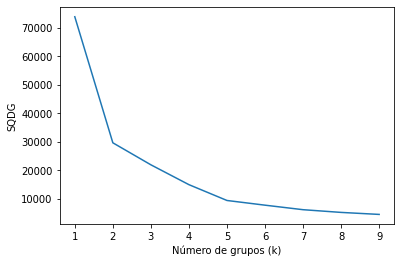

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(moran_matrix_sul.drop('geometry', axis=1))
    moran_matrix_sul['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [ ]:
k = 5

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, kmeans.labels_, metric='euclidean'),2)  
)

358.48 1.69 0.66


In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
moran_matrix_sul['grupo'] = kmeans.labels_

In [ ]:
# contagens
moran_matrix_sul.grupo.value_counts()

0    1097
2      84
3       5
4       3
1       2
Name: grupo, dtype: int64

In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix_sul.groupby('grupo').mean()

apolices_contratadas  total_segurado_mil  ...  apolices_indenizadas    grupos
grupo                                            ...                                
0                  0.153226            0.142651  ...              0.082740  1.051048
1                 28.852705            9.616870  ...             74.228352  4.000000
2                  3.623903            2.452423  ...              2.427107  6.464286
3                 24.234086            8.405900  ...             36.559578  3.000000
4                  3.042600           20.720090  ...              0.247381  6.000000

[5 rows x 9 columns]

In [ ]:
# mediana das variáveis para cada grupo
moran_matrix_sul.groupby('grupo').median()

apolices_contratadas  total_segurado_mil  ...  apolices_indenizadas  grupos
grupo                                            ...                              
0                  0.139611            0.136964  ...              0.080003       1
1                 28.852705            9.616870  ...             74.228352       4
2                  2.834980            1.643358  ...              1.488537       8
3                 24.723952           10.400309  ...             37.372495       2
4                  3.020046           22.996490  ...              0.177101       6

[5 rows x 9 columns]

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

In [ ]:
#grupo1 = mg.query('grupo == 1').index
#list(grupo1)

In [ ]:
#grupo2 = mg.query('grupo == 2').index
#list(grupo2)

### Mapa Grupos com I de Moran - Sul

In [ ]:
moran_matrix_sul['grupo'] = moran_matrix_sul['grupo'].astype('category')

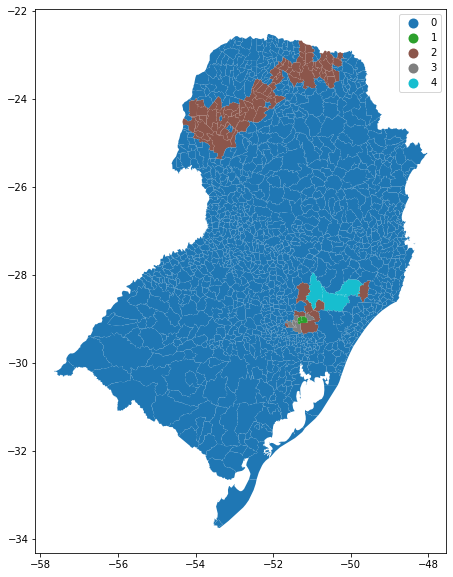

In [ ]:
moran_matrix_sul.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## Matriz de G de Getis-Ord - Sul

Teste de construção de uma matriz de G de Getis-Ord para cada variável


### Criando a matriz

In [ ]:
getis_matrix_sul = dados_sul

In [ ]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'Unnamed: 0', 'rm'] # , 'geometry'
getis_matrix_sul = getis_matrix_sul.drop(retirar, axis = 1)

### G de Getis Ord local para variáveis - Sul

In [ ]:
getis_matrix_sul.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [ ]:
# demora um pouco
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [ ]:
getis_matrix_sul['apolices_contratadas'] = G_Local(dados_sul['apolices_contratadas'].values, w).Zs
getis_matrix_sul['total_segurado_mil'] = G_Local(dados_sul['total_segurado_mil'].values, w).Zs
getis_matrix_sul['soma_premio_total_mil'] = G_Local(dados_sul['soma_premio_total_mil'].values, w).Zs
getis_matrix_sul['total_subvencao_mil'] = G_Local(dados_sul['total_subvencao_mil'].values, w).Zs
getis_matrix_sul['valor_indenizacoes_pagas_mil'] = G_Local(dados_sul['valor_indenizacoes_pagas_mil'].values, w).Zs
getis_matrix_sul['sinistralidade_media'] = G_Local(dados_sul['sinistralidade_media'].values, w).Zs
getis_matrix_sul['taxa_media'] = G_Local(dados_sul['taxa_media'].values, w).Zs
getis_matrix_sul['apolices_indenizadas'] = G_Local(dados_sul['apolices_indenizadas'].values, w).Zs
# Podia ser feito de um jeito mais inteligente? Podia

In [ ]:
getis_matrix_sul = getis_matrix_sul.set_index('nome_mun')

In [ ]:
getis_matrix_sul.describe()

apolices_contratadas  ...  apolices_indenizadas
count           1191.000000  ...           1191.000000
mean               0.068056  ...              0.034747
std                0.818446  ...              0.779678
min               -0.473328  ...             -0.309403
25%               -0.426997  ...             -0.301196
50%               -0.261540  ...             -0.252032
75%                0.185899  ...             -0.042124
max                5.829321  ...              8.876354

[8 rows x 8 columns]

### Mapa G de Getis Ord - Sul

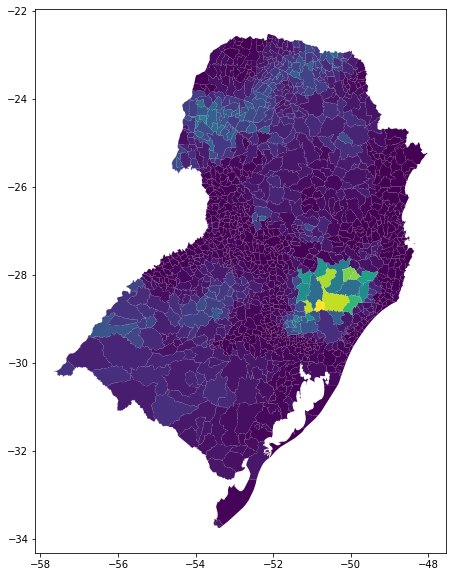

In [ ]:
getis_matrix_sul.plot(column='soma_premio_total_mil', figsize=(10, 10),  k=4); # , cmap='OrRd'

## Análise de agrupamento - G de Getis-Ord - Sul

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

In [ ]:
# subselecionar variáveis
X = getis_matrix_sul.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

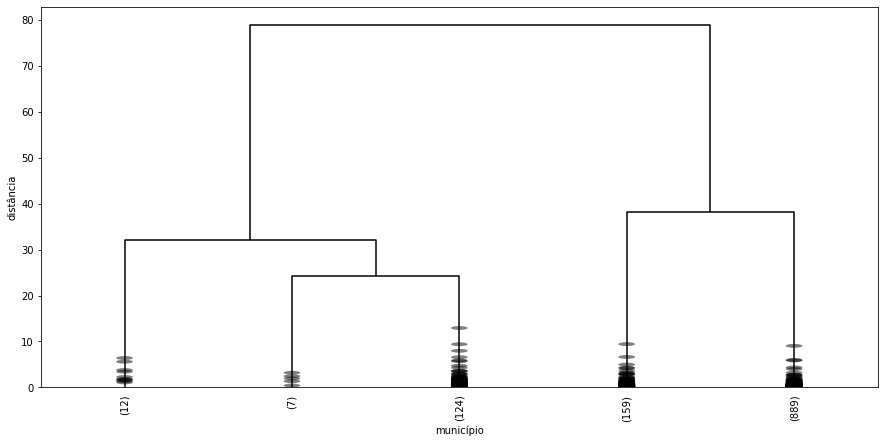

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
# definir a distância de corte baseando no dendrograma
max_d = 20
grupos = cut_tree(Z, height=max_d)

### Métricas

In [ ]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, grupos.ravel(), metric='euclidean'),2)  
)

124.48 7.1 0.33


In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
getis_matrix_sul['grupo'] = grupos
# moran_matrix.head(2)

In [ ]:
# contagem de observações em cada grupo
getis_matrix_sul.grupo.value_counts()

1    889
2    159
0    124
3     12
4      7
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix_sul.groupby('grupo').mean()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                  1.618150  ...              1.209681
1                 -0.273890  ...             -0.247045
2                  0.371137  ...              0.274597
3                  4.395400  ...              5.362765
4                  1.733886  ...              0.427512

[5 rows x 8 columns]

In [ ]:
# mediana das variáveis para cada grupo
getis_matrix_sul.groupby('grupo').median()

apolices_contratadas  ...  apolices_indenizadas
grupo                        ...                      
0                  1.528732  ...              1.175909
1                 -0.365900  ...             -0.283118
2                  0.346387  ...              0.150808
3                  4.290481  ...              4.780325
4                  1.893713  ...              0.433683

[5 rows x 8 columns]

### As observações de cada grupo

In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

In [ ]:
#grupo1 = dados.query('grupo == 1').index
#list(grupo1)

In [ ]:
#grupo2 = dados.query('grupo == 2').index
#list(grupo2)

In [ ]:
# plotar os escores dos CPs dos grupos
#sns.lmplot('cp1', 'cp2', hue='grupo', fit_reg=False, data=moran_matrix, aspect=1.5);

In [ ]:
# pacote altair para fazer outros tipos de gráficos
# usaremos para o diagrama de dispersão com a cor
# import altair as alt

### Mapa Grupos G de Getis-Ords - Sul

## K-Médias G de Getis-Ord - Sul

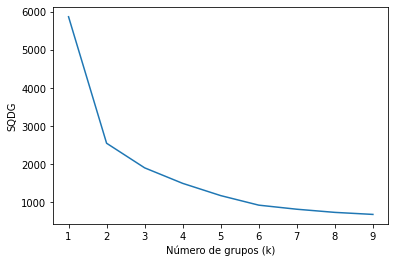

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(getis_matrix_sul.drop('geometry', axis=1))
    getis_matrix_sul['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [ ]:
k = 5

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
getis_matrix_sul['grupo'] = kmeans.labels_

### Métricas

In [ ]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, kmeans.labels_, metric='euclidean'),2)  
)

125.24 18.59 0.35


In [ ]:
# contagens
getis_matrix_sul.grupo.value_counts()

0    829
1    223
2    114
4     13
3     12
Name: grupo, dtype: int64

In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix_sul.groupby('grupo').mean()

apolices_contratadas  total_segurado_mil  ...  apolices_indenizadas    grupos
grupo                                            ...                                
0                 -0.308670           -0.279372  ...             -0.258471  1.276236
1                  0.355174            0.463467  ...              0.160764  5.053812
2                  1.648641            1.301798  ...              1.332802  2.692982
3                  4.395400            2.681850  ...              5.362765  5.000000
4                  1.311433            3.106098  ...              0.270219  5.384615

[5 rows x 9 columns]

In [ ]:
# mediana das variáveis para cada grupo
getis_matrix_sul.groupby('grupo').median()

apolices_contratadas  total_segurado_mil  ...  apolices_indenizadas  grupos
grupo                                            ...                              
0                 -0.382112           -0.372921  ...             -0.289690       1
1                  0.310121            0.397888  ...              0.048720       3
2                  1.593749            1.224535  ...              1.203046       0
3                  4.290481            2.828896  ...              4.780325       5
4                  1.368501            2.673483  ...              0.291655       4

[5 rows x 9 columns]

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

In [ ]:
#grupo1 = mg.query('grupo == 1').index
#list(grupo1)

In [ ]:
#grupo2 = mg.query('grupo == 2').index
#list(grupo2)

### Mapa Grupos com G de Getis Ord - k-médias - Sul

In [ ]:
getis_matrix_sul['grupo'] = getis_matrix_sul['grupo'].astype('category')

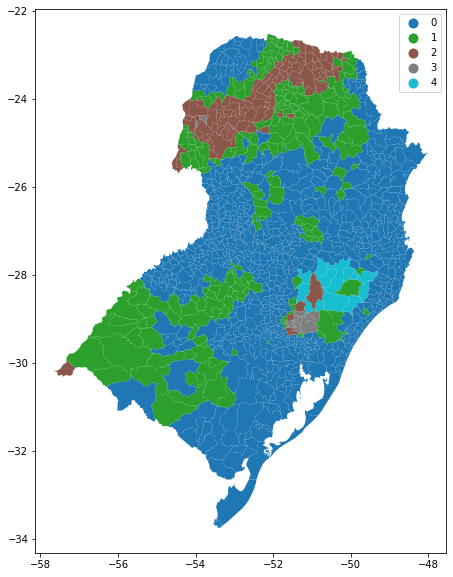

In [ ]:
getis_matrix_sul.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## Centroides




In [ ]:
dados_br.geometry.centroid.x

dados_br['x_centroid'] = dados_br.geometry.centroid.x
dados_br['y_centroid'] = dados_br.geometry.centroid.y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [ ]:
dados_centroids = dados_br
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # 
dados_centroids = dados_centroids.drop(retirar, axis = 1)

## Análise de agrupamento - Centroides

In [ ]:
# subselecionar variáveis
X = dados_centroids.drop(['nome_mun', 'geometry'], axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

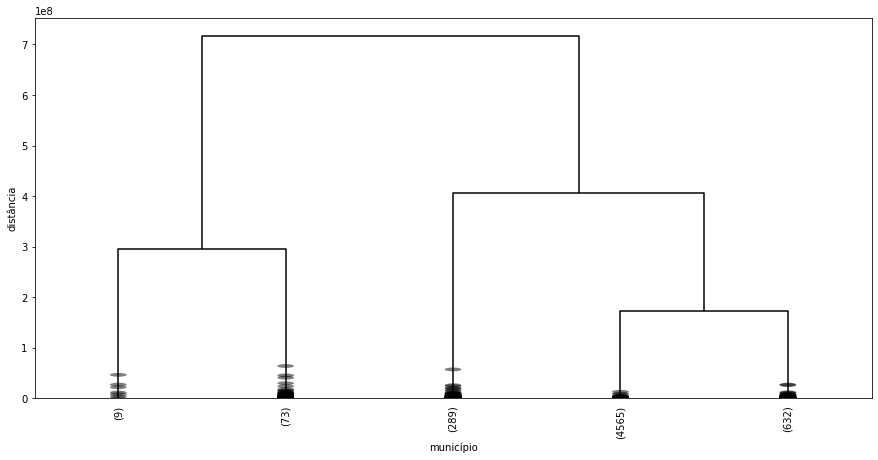

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

Método escolhido:

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
## definir a distância de corte baseando no dendrograma
max_d = 2e8
grupos = cut_tree(Z, height=max_d)

### Métricas

In [ ]:
retirar = ['uf', 'nome_uf', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry',] # 
dados_metrics = dados_br.drop(retirar, axis = 1)

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics.values, grupos.ravel(), metric='euclidean'),2)  
)

13027.26 0.5 0.88


In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = grupos
# moran_matrix.head(2)

In [ ]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

0    5197
1     289
2      73
3       9
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

apolices_contratadas  total_segurado_mil  ...  x_centroid  y_centroid
grupo                                            ...                        
0                  4.617856        8.115662e+05  ...  -45.920369  -16.065168
1                 96.200692        1.806478e+07  ...  -50.777996  -21.885787
2                229.808219        4.974890e+07  ...  -51.261608  -21.888229
3                339.000000        1.229835e+08  ...  -51.000714  -21.899415

[4 rows x 10 columns]

In [ ]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

apolices_contratadas  total_segurado_mil  ...  x_centroid  y_centroid
grupo                                            ...                        
0                       0.0        0.000000e+00  ...  -45.814586  -17.078147
1                      73.0        1.712127e+07  ...  -51.330066  -23.348594
2                     166.0        4.402479e+07  ...  -52.265995  -23.341657
3                     343.0        1.141694e+08  ...  -50.924125  -22.699261

[4 rows x 10 columns]

### As observações de cada grupo

In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides

In [ ]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

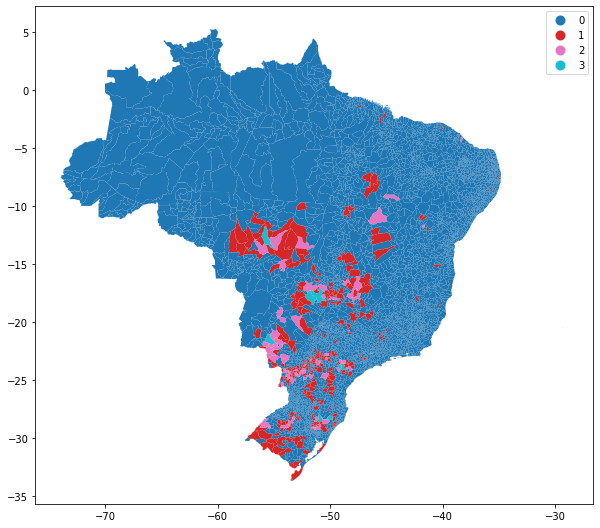

In [ ]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## K-Médias

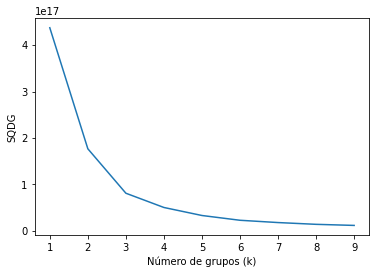

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
    dados_centroids['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [ ]:
k = 4

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [ ]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

14319.26 0.53 0.87


In [ ]:
# contagens
dados_centroids.grupo.value_counts()

0    4985
3     427
1     129
2      27
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

apolices_contratadas  total_segurado_mil  ...  y_centroid    grupos
grupo                                            ...                      
0                  2.832096        4.904948e+05  ...  -15.818728  2.694283
1                170.542636        3.266863e+07  ...  -22.310448  4.891473
2                322.962963        9.006959e+07  ...  -21.163289  4.222222
3                 62.740047        1.191031e+07  ...  -21.791083  5.346604

[4 rows x 11 columns]

In [ ]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

apolices_contratadas  total_segurado_mil  ...  y_centroid  grupos
grupo                                            ...                    
0                       0.0                0.00  ...  -16.584787       3
1                     153.0         29105606.53  ...  -23.341657       7
2                     218.0         76597614.84  ...  -22.699261       5
3                      47.0         11197997.88  ...  -23.333497       6

[4 rows x 11 columns]

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroide K-médias

In [ ]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

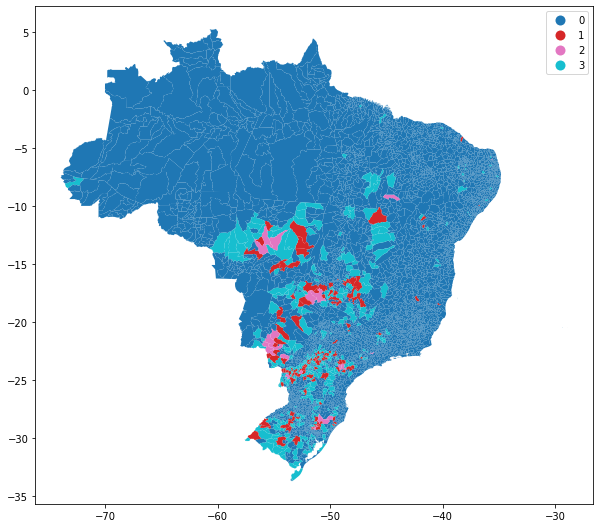

In [ ]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## Centroides Sul

In [ ]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/p

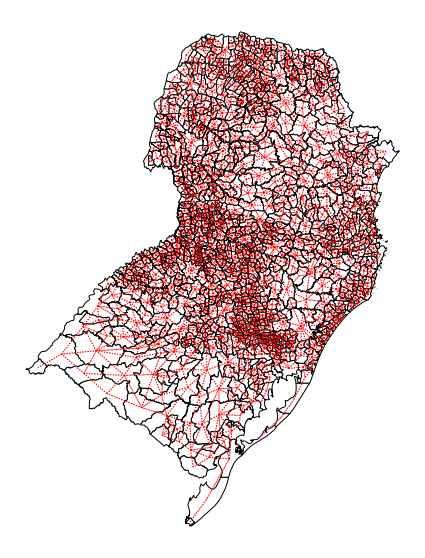

In [ ]:
wq = Queen.from_dataframe(dados_sul)
wq.transform = 'r'
ax = dados_sul.plot(edgecolor='k', facecolor='w', figsize=(10, 10))
wq.plot(dados_sul, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [ ]:
dados_sul.geometry.centroid.x

dados_sul['x_centroid'] = dados_sul.geometry.centroid.x
dados_sul['y_centroid'] = dados_sul.geometry.centroid.y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [ ]:
dados_centroids = dados_sul
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'rm'] # , 'geometry'
dados_centroids = dados_centroids.drop(retirar, axis = 1)

## Análise de agrupamento - Centroides - Sul

In [ ]:
# subselecionar variáveis
X = dados_centroids.drop(['nome_mun', 'geometry'], axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

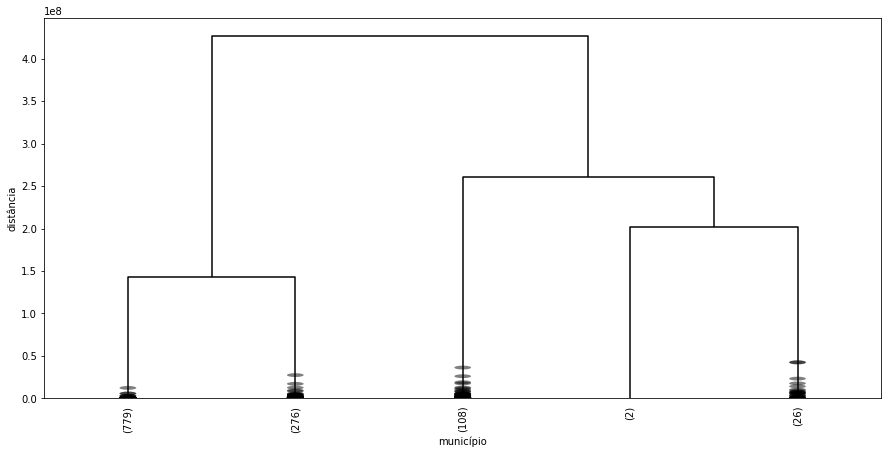

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
## definir a distância de corte baseando no dendrograma
max_d = 1e8
grupos = cut_tree(Z, height=max_d)

### Métricas

In [ ]:
retirar = ['uf', 'nome_uf', 'rm', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry','Unnamed: 0', 'x_centroid', 'y_centroid'] # 
dados_metrics_sul = dados_sul.drop(retirar, axis = 1)

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, grupos.ravel(), metric='euclidean'),2)  
)

3073.27 0.51 0.7


In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = grupos
# moran_matrix.head(2)

In [ ]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

1    779
0    276
2    108
3     26
4      2
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

Unnamed: 0  apolices_contratadas  ...  x_centroid  y_centroid
grupo                                     ...                        
0      4425.876812             53.163043  ...  -52.110708  -26.432805
1      4563.540436              4.894737  ...  -51.760589  -27.377175
2      4328.064815            150.824074  ...  -52.197252  -25.978664
3      4393.461538            339.538462  ...  -52.543690  -26.185446
4      4818.000000            487.000000  ...  -50.468961  -28.334531

[5 rows x 11 columns]

In [ ]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

Unnamed: 0  apolices_contratadas  ...  x_centroid  y_centroid
grupo                                    ...                        
0          4300.5                  45.0  ...  -52.025529  -26.165986
1          4563.0                   1.0  ...  -52.004892  -27.466400
2          4201.0                 136.0  ...  -51.997383  -24.717221
3          4287.5                 289.5  ...  -52.355093  -24.952826
4          4818.0                 487.0  ...  -50.468961  -28.334531

[5 rows x 11 columns]

### As observações de cada grupo

In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides Sul

In [ ]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

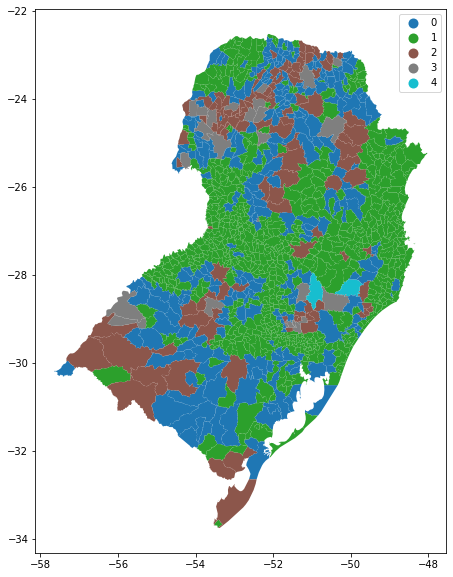

In [ ]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## K-Médias - Sul

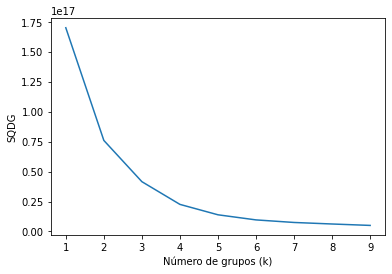

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
    dados_centroids['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [ ]:
k = 4

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [ ]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, kmeans.labels_, metric='euclidean'),2)  
)

2582.05 0.48 0.76


In [ ]:
# contagens
dados_centroids.grupo.value_counts()

0    974
2    187
1     28
3      2
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

Unnamed: 0  apolices_contratadas  ...  y_centroid    grupos
grupo                                     ...                      
0      4538.658111             12.715606  ...  -27.199693  1.718686
1      4382.464286            332.071429  ...  -26.072049  2.464286
2      4357.427807            117.219251  ...  -26.129802  3.524064
3      4818.000000            487.000000  ...  -28.334531  5.500000

[4 rows x 12 columns]

In [ ]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

Unnamed: 0  apolices_contratadas  ...  y_centroid  grupos
grupo                                    ...                    
0          4544.5                   3.0  ...  -27.409426     0.0
1          4287.5                 289.5  ...  -24.791050     1.0
2          4239.0                 100.0  ...  -25.007503     4.0
3          4818.0                 487.0  ...  -28.334531     5.5

[4 rows x 12 columns]

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides K-médias Sul

In [ ]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

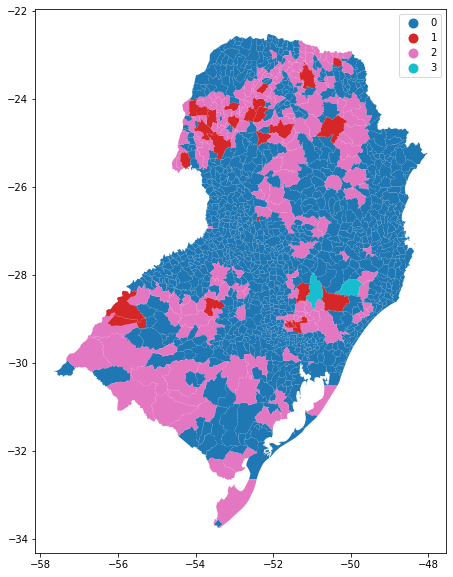

In [ ]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## Latitude e Longitude municípios

In [ ]:
cod_ll = pd.read_csv('https://raw.githubusercontent.com/walefmachado/Municipios-Brasileiros/master/csv/municipios.csv')

In [ ]:
cod_ll.columns

Index(['codigo_ibge', 'nome', 'latitude', 'longitude', 'capital', 'codigo_uf'], dtype='object')

In [ ]:
cod_ll = cod_ll.rename(columns={'codigo_ibge': 'mun'})
cod_ll.mun = cod_ll.mun.astype(int)


In [ ]:
cod_ll.head()

mun                 nome  latitude  longitude  capital  codigo_uf
0  5200050      Abadia de Goiás -16.75730   -49.4412        0         52
1  3100104  Abadia dos Dourados -18.48310   -47.3916        0         31
2  5200100            Abadiânia -16.19700   -48.7057        0         52
3  3100203               Abaeté -19.15510   -45.4444        0         31
4  1500107           Abaetetuba  -1.72183   -48.8788        0         15

In [ ]:
retirar = ['nome', 'capital', 'codigo_uf']
cod_ll = cod_ll.drop(retirar, axis=1)

In [ ]:
dados_ll = dados_sul.merge(cod_ll, on='mun', how='left')


In [ ]:
dados_ll.head()

Unnamed: 0  uf nome_uf      mun  ... x_centroid y_centroid  latitude longitude
0        3912  41  Paraná  4100103  ... -50.309008 -23.307072  -23.3049  -50.3133
1        3913  41  Paraná  4100202  ... -48.820593 -24.783544  -24.6606  -48.9922
2        3914  41  Paraná  4100301  ... -49.311487 -26.027042  -25.9899  -49.3343
3        3915  41  Paraná  4100400  ... -49.323534 -25.295348  -25.3188  -49.3037
4        3916  41  Paraná  4100459  ... -52.691416 -24.813268  -24.7983  -52.7128

[5 rows x 26 columns]

In [ ]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 'Unnamed: 0', 
           'nome_regiao', 'rm', 'x_centroid', 'y_centroid'] # , 'geometry'
dados_ll = dados_ll.drop(retirar, axis = 1)

In [ ]:
# subselecionar variáveis
X = dados_ll.drop(['nome_mun', 'geometry'], axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

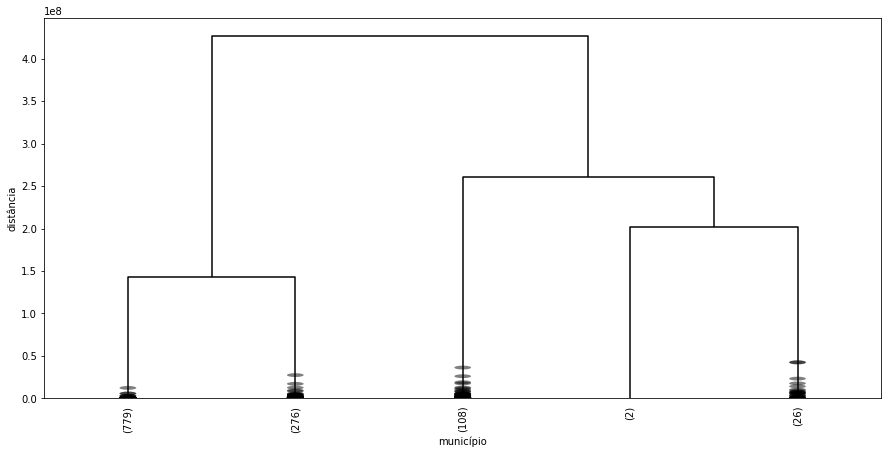

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [ ]:
Z = linkage(X, method='ward')

In [ ]:
## definir a distância de corte baseando no dendrograma
max_d = 1e8
grupos = cut_tree(Z, height=max_d)

### Métricas

In [ ]:
retirar = ['uf', 'nome_uf', 'rm', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry','Unnamed: 0', 'x_centroid', 'y_centroid'] # 
dados_metrics_sul = dados_sul.drop(retirar, axis = 1)

In [ ]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, grupos.ravel(), metric='euclidean'),2)  
)

3073.27 0.51 0.7


In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_lg['grupo'] = grupos
# moran_matrix.head(2)

In [ ]:
# contagem de observações em cada grupo
dados_lg.grupo.value_counts()

1    779
0    276
2    108
3     26
4      2
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lg.groupby('grupo').mean()

apolices_contratadas  total_segurado_mil  ...   latitude  longitude
grupo                                            ...                      
0                 53.163043        7.629918e+06  ... -26.432693 -52.105488
1                  4.894737        5.849156e+05  ... -27.384497 -51.758609
2                150.824074        2.173028e+07  ... -25.976036 -52.197929
3                339.538462        5.297683e+07  ... -26.160373 -52.551396
4                487.000000        1.557418e+08  ... -28.398300 -50.443750

[5 rows x 10 columns]

In [ ]:
# mediana das variáveis para cada grupo
dados_lg.groupby('grupo').median()

apolices_contratadas  total_segurado_mil  ...  latitude  longitude
grupo                                            ...                     
0                      45.0        7.322614e+06  ... -26.12745  -52.01000
1                       1.0        1.421334e+05  ... -27.47890  -52.02380
2                     136.0        2.074869e+07  ... -24.77395  -51.99000
3                     289.5        4.777482e+07  ... -24.92130  -52.32350
4                     487.0        1.557418e+08  ... -28.39830  -50.44375

[5 rows x 10 columns]

### As observações de cada grupo

In [ ]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides Sul

In [ ]:
dados_lg['grupo'] = dados_lg['grupo'].astype('category')

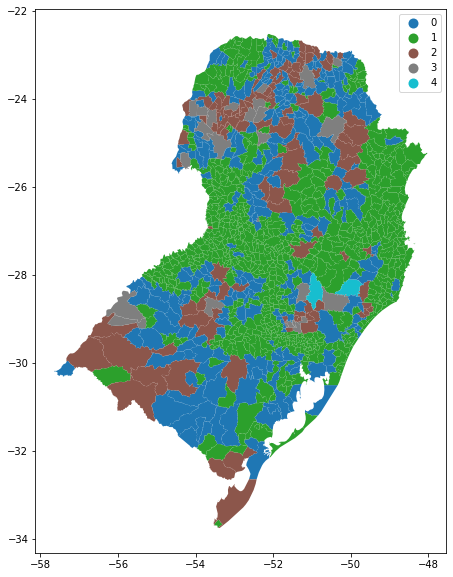

In [ ]:
dados_lg.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

## K-Médias - Sul

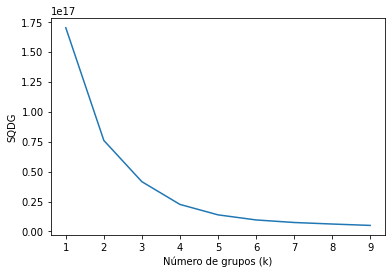

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_ll.drop(['nome_mun', 'geometry'], axis=1))
    dados_ll['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [ ]:
k = 4

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [ ]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics.values, kmeans.labels_, metric='euclidean'),2)  
)

2582.05 0.48 0.76


In [ ]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_lg['grupo'] = kmeans.labels_

In [ ]:
# contagens
dados_lg.grupo.value_counts()

0    974
2    187
1     28
3      2
Name: grupo, dtype: int64

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_lg.groupby('grupo').mean()

apolices_contratadas  total_segurado_mil  ...  longitude    grupos
grupo                                            ...                     
0                 12.715606        1.669794e+06  ... -51.819905  0.776181
1                332.071429        5.174681e+07  ... -52.538657  3.964286
2                117.219251        1.716836e+07  ... -52.198468  6.299465
3                487.000000        1.557418e+08  ... -50.443750  5.000000

[4 rows x 11 columns]

In [ ]:
# mediana das variáveis para cada grupo
dados_lg.groupby('grupo').median()

apolices_contratadas  total_segurado_mil  ...  longitude  grupos
grupo                                            ...                   
0                       3.0        3.677447e+05  ...  -52.02490       0
1                     289.5        4.623080e+07  ...  -52.32350       5
2                     100.0        1.555107e+07  ...  -51.98880       7
3                     487.0        1.557418e+08  ...  -50.44375       5

[4 rows x 11 columns]

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides K-médias Sul

In [ ]:
dados_lg['grupo'] = dados_lg['grupo'].astype('category')

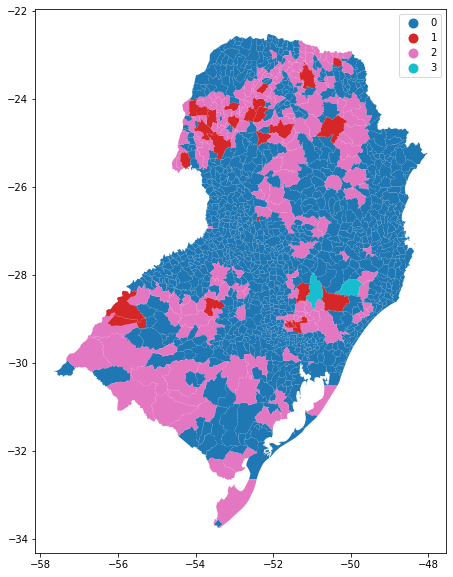

In [ ]:
dados_lg.plot(column='grupo', figsize=(10, 10), legend=True, k=4); # , cmap='OrRd'

# THE END